In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain

In [2]:
df = pd.read_csv('news_file.csv')
df['date'] = pd.to_datetime(df['created_at'])
df.shape

(24961, 4)

In [3]:
df.head()

,text,created_at,source,date
0,"JUST IN: The US economy added 164,000 jobs in ...",2019-08-02 12:42:16+00:00,CNNPolitics,2019-08-02 12:42:16+00:00
1,"Dayton mayor ""at a loss"" for why President Tru...",2019-08-08 14:43:03+00:00,CNNPolitics,2019-08-08 14:43:03+00:00
2,Hillary Clinton says staying in her marriage w...,2019-10-01 15:46:30+00:00,CNNPolitics,2019-10-01 15:46:30+00:00
3,"Fire crews, air drops and a herd of goats help...",2019-10-31 21:35:04+00:00,CNNPolitics,2019-10-31 21:35:04+00:00
4,Elizabeth Warren slams Michael Bloomberg: He's...,2019-11-27 00:11:04+00:00,CNNPolitics,2019-11-27 00:11:04+00:00


# Check data

In [4]:
df['date'].min()

Timestamp('2019-08-01 00:02:10+0000', tz='UTC')

In [5]:
df['date'].max()

Timestamp('2019-11-29 23:45:04+0000', tz='UTC')

# preprocess tweets

In [6]:
%%time
# tokenization = split sentences into word strings
df['tokens'] = df['text'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization = converting a word to its base form, different from stemming
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 17.1 s


# Check frequency

In [7]:
pd.set_option('display.max_rows', 500)

#create [[str, str,...] ...] and chain(*) returns each str in each list 
all_words = pd.Series(chain(*list(df['processed']))) 
word_frequency = all_words.value_counts()
word_frequency

http                 24867
trump                 8345
president             4694
’                     3864
house                 2546
impeachment           2405
ha                    1795
new                   1639
say                   1549
democratic            1442
democrats             1289
wa                    1276
“                     1228
biden                 1220
ukraine               1190
said                  1179
white                 1099
former                1093
donald                1035
u.s.                  1008
2020                  1004
analysis               961
inquiry                953
state                  945
joe                    938
debate                 868
presidential           839
candidate              818
campaign               813
week                   786
”                      777
official               728
call                   718
—                      692
administration         678
would                  655
warren                 641
r

# top 10 candidates

In [8]:
candidate_list = ["bennet", "biden", "bloomberg", "booker", "bullock", "buttigieg",\
                  "castro", "delaney", "babbard", "harris", "klobuchar", "patrick",\
                  "sanders", "sestak", "steyer", "warren", "williamson", "yang"]

In [9]:
tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(candidate_list)
candidate_frequency = word_frequency[mask]
top10_candidates = candidate_frequency.head(10)
top10_candidates

biden        1220
warren        641
sanders       480
harris        326
buttigieg     320
yang          178
booker        177
castro        170
bloomberg     127
klobuchar      86
dtype: int64

# lift ratios between candidates

In [10]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

In [11]:
lift_candidates = pd.DataFrame(top10_candidates.index.values, columns=['candidates']) #initialize df 
for candidate in top10_candidates.index.values:
    lift_candidates[candidate] = lift_candidates['candidates'].map(lambda x: lift(x, candidate)) #create lift column for each candidate 
lift_candidates = lift_candidates.set_index('candidates')
lift_candidates

,biden,warren,sanders,harris,buttigieg,yang,booker,castro,bloomberg,klobuchar
candidates,,,,,,,,,,
biden,20.459836,4.947386,2.685353,4.518737,2.941101,0.574714,7.051130,4.814079,0.322202,1.427430
warren,4.947386,38.940718,7.707017,1.075050,2.190415,0.000000,1.100020,0.458126,2.146339,2.716794
sanders,2.685353,7.707017,52.002083,0.957094,1.462559,0.876440,1.468985,0.917684,2.047326,1.209351
harris,4.518737,1.075050,0.957094,76.567485,2.392734,2.580926,8.219109,3.152779,0.000000,2.670959
buttigieg,2.941101,2.190415,1.462559,2.392734,78.003125,0.438220,7.491826,5.047261,0.614198,10.884157
yang,0.574714,0.000000,0.876440,2.580926,0.438220,140.230337,4.753571,1.649769,2.208352,1.630585
booker,7.051130,1.100020,1.468985,8.219109,7.491826,4.753571,141.022599,14.102260,0.000000,1.639798
castro,4.814079,0.458126,0.917684,3.152779,5.047261,1.649769,14.102260,146.829412,0.000000,6.829275
bloomberg,0.322202,2.146339,2.047326,0.000000,0.614198,2.208352,0.000000,0.000000,196.543307,6.856162


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


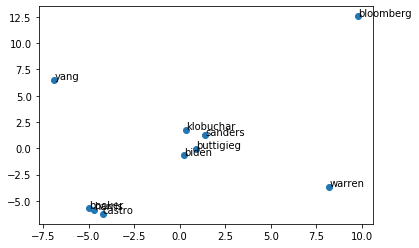

In [15]:
inverse_lift_candidates = lift_candidates.apply(lambda x: 1/(x+0.1))

from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline  

embedding = MDS(n_components=2, random_state=10)
mds = embedding.fit_transform(inverse_lift_candidates)
mds_output = pd.DataFrame(mds, index=inverse_lift_candidates.index.values, columns=['x', 'y'])

fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for candidate in inverse_lift_candidates.index.values:
    ax.text(mds_output.loc[candidate, 'x']+0.02, mds_output.loc[candidate, 'y']+0.02, candidate)

# policy connections

In [16]:
word_frequency[:500]

http              24867
trump              8345
president          4694
’                  3864
house              2546
impeachment        2405
ha                 1795
new                1639
say                1549
democratic         1442
democrats          1289
wa                 1276
“                  1228
biden              1220
ukraine            1190
said               1179
white              1099
former             1093
donald             1035
u.s.               1008
2020               1004
analysis            961
inquiry             953
state               945
joe                 938
debate              868
presidential        839
candidate           818
campaign            813
week                786
”                   777
official            728
call                718
—                   692
administration      678
would               655
warren              641
rep.                628
senate              621
plan                601
one                 592
republican      

In [26]:
policy_dict = { "leadership": ["lead", "plan", "leading", "help", "qualified", "leader"],
                "experience":["former", "know", "time", "year"],
                "popularity":["support", "want", "win", "top", "watch", "best", "back", "potential", "great", "believe",\
                              "love", "supporting"],
                "progressive": ["change", "idea", "socialist", "progressive", "liberal", "socialism"], 
                "education": ["school", "college", "university"],
                "taxes": ["tax", "money", "billionaire", "pay", "wealth", "rich"],
                "jobs": ["work", "job"],
                "health": ["health", "care", "live", "life", "medicare", "healthcare"],
                "social": ["women", "family", "choice", "child"],
                "poverty": ["poor", "help"],
                "climate": ["climate"],
                "military": ["military", "war", "fight"],
                "unpopular": ["corrupt", "bad", "hate", "stupid", "corruption", "criminal", "racist"],
                "immigration": ['immigrations', "immigrants", "immigration", "immigrant", "migration"],
                "gun": ["gun", "guns", "handgun", "firearm", "pistol", "firearms", "weapon"],
                "economic": ['economic', 'social', 'security', 'financial', "equality", 'inequality', "egalitarianism"],
              "criminal justice": ['justice', 'injustice', 'criminal', 'judicial'],
               "woman rights": ['woman', 'lady', 'women', 'rights', 'liberties'],
              "democracy": ['democracy', 'democracies', "democratization", "autocracy"],
              "lgbt": ['lgbt', 'gay', 'lgbtq', 'lgbtqi']}

In [27]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_policy = pd.DataFrame(pd.Series(policy_dict), columns=['policy_terms'])
top_policy['count'] = top_policy['policy_terms'].map(lambda x: count_attribute(df, x))

top_policy.sort_values(by=['count'], ascending=False)

,policy_terms,count
popularity,"[support, want, win, top, watch, best, back, p...",2351
experience,"[former, know, time, year]",2150
leadership,"[lead, plan, leading, help, qualified, leader]",1494
economic,"[economic, social, security, financial, equali...",723
health,"[health, care, live, life, medicare, healthcare]",712
military,"[military, war, fight]",681
gun,"[gun, guns, handgun, firearm, pistol, firearms...",619
taxes,"[tax, money, billionaire, pay, wealth, rich]",510
progressive,"[change, idea, socialist, progressive, liberal...",500
criminal justice,"[justice, injustice, criminal, judicial]",453


In [20]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [28]:
candidates_list = pd.Series(index=['warren', 'sanders', 'biden', 'bloomberg'])

for attribute in top_policy.index.values:
    print(attribute)
    output = lift_attribute_to_brands(attribute, policy_dict, candidates_list, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(output)
    print('')

leadership
warren       3.205963
sanders      2.192859
biden        1.643360
bloomberg    0.657775
dtype: float64

experience
bloomberg    2.468218
biden        1.389366
sanders      0.967481
warren       0.561471
dtype: float64

popularity
sanders      1.305029
biden        1.026908
bloomberg    1.003199
warren       0.960681
dtype: float64

progressive
sanders      1.976079
warren       1.557629
bloomberg    0.786173
biden        0.654715
dtype: float64

education
warren       1.603441
biden        1.203520
sanders      0.611789
bloomberg    0.000000
dtype: float64

taxes
bloomberg    5.395306
warren       2.977820
sanders      2.549122
biden        0.962816
dtype: float64

jobs
sanders      1.304712
biden        1.173324
bloomberg    0.704456
warren       0.697862
dtype: float64

health
warren       3.281521
sanders      3.140575
biden        1.321843
bloomberg    0.000000
dtype: float64

social
biden        1.750251
sanders      0.460195
warren       0.344608
bloomberg    0.000000
